## Installing Dependencies

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import glob
import os
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

c:\MLAI\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data-laoding and Preprocessing

In [2]:
# Data augmentation and normalization for training
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])
transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
     transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
#Loading the data
train_dir = r"C:\MLAI\Coursework\IVC\Coursework\marvel\marvel\train"

In [6]:
train_dataset = datasets.ImageFolder(train_dir, transforms_train)

In [7]:
train, valid= torch.utils.data.random_split(train_dataset, [2000, 584])

In [8]:
train_dataloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True, num_workers=1)
valid_dataloader = torch.utils.data.DataLoader(valid, batch_size=32, shuffle=False, num_workers=1)

In [9]:
print('Train dataset size:', len(train))
print('Valid dataset size:', len(valid))
class_names = train_dataset.classes
print('Class names:', class_names)

### Visualising dataset

In [10]:
plt.rcParams['figure.figsize'] = [24,16]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})
def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()
# load a batch of train image
iterator = iter(train_dataloader)
# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:8])
imshow(out, title=[class_names[x] for x in classes[:8]])

## Training Model

### Initializing Model

In [11]:
#Using the pre-trained model Resnet18
model = models.resnet18()
print(model)
#load resnet18 model
num_features = model.fc.in_features     #extract fc layers features
model.fc = nn.Linear(num_features, 8) #(num_of_class == 8)
model = model.to(device) 
criterion = nn.CrossEntropyLoss()  #(set loss function)#weight=class.weights.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [13]:
filepath = r"C:\MLAI\Coursework\IVC\Coursework\Save_Path.pt"

checkpoint = torch.load(filepath)
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
epoch = checkpoint['epoch']

### Training

In [ ]:
num_epochs = 60   #(set no of epochs)
start_time = time.time() #(for showing time)
for epoch in range(num_epochs): #(loop for every epoch)
    print("Epoch {} running".format(epoch)) #(printing message)
    
    """ Training Phase """
    model.train()    #(training model)
    running_loss = 0.   #(set loss 0)
    running_corrects = 0 
    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device) 
        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        # get loss value and update the network weights
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() -start_time))
    
    """ Validation Phase """
    model.train()
    running_loss = 0.
    running_corrects = 0 
    for i, (inputs, labels) in enumerate(valid_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device) 
        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        # get loss value and update the network weights
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    state = {
    'epoch': epoch,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'loss':loss
    }
    torch.save(state, filepath)
    print('[Valid #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() -start_time))

In [ ]:
#Plot of accuracy of Val v/s train
#train_val_acc_df = 
#pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

# Plot the dataframes
#fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
#sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')

### Archive


In [16]:
# save_path = r"C:\MLAI\Coursework\IVC\Coursework\Save_Path.pt"

In [ ]:
# model = models.resnet18()  #load resnet18 model
# num_features = model.fc.in_features #extract fc layers features
# model.fc = nn.Linear(num_features, 8)#(num_of_class == 8)
# model.load_state_dict(torch.load(save_path))
# model.to(device)

In [ ]:
# filepath = r"C:\MLAI\Coursework\IVC\Coursework\Save_Path.pt"

In [ ]:
# checkpoint = torch.load(filepath)
# model.load_state_dict(checkpoint['state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer'])
# epoch = checkpoint['epoch']

In [ ]:
# num_epochs = 1 #(set no of epochs)
# start_time = time.time() #(for showing time)
# for epoch in range(num_epochs): #(loop for every epoch)
#     print("Epoch {} running".format(epoch)) #(printing message)
 
#     """ Testing Phase """
#     model.eval()
#     with torch.no_grad():
#         running_loss = 0.
#         running_corrects = 0
#         for inputs, labels in test_dataloader:
#             inputs = inputs.to(device)
#             labels = labels.to(device)
#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)
#             loss = criterion(outputs, labels)
#             running_loss += loss.item() * inputs.size(0)
#             running_corrects += torch.sum(preds == labels.data)
#         epoch_loss = running_loss / len(test_dataset)
#         epoch_acc = running_corrects / len(test_dataset) * 100.
#         print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.
#               format(epoch, epoch_loss,epoch_acc, time.time() - start_time))


======>RESULTS<======


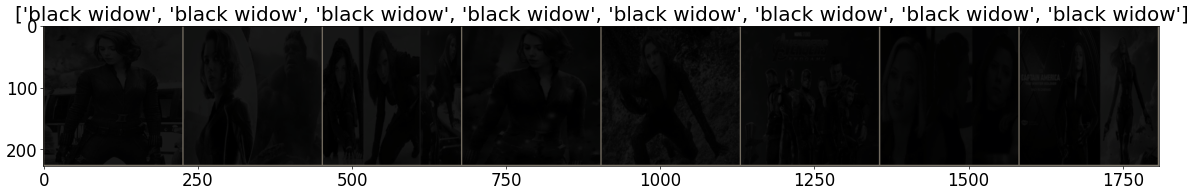

[Test #0] Loss: 3.3287 Acc: 21.0643% Time: 4.1451s


In [74]:
num_epochs = 1 #(set no of epochs)
start_time = time.time() #(for showing time)
val_acc=[]
train_acc=[]
for epoch in range(num_epochs): #(loop for every epoch)
    plt.rcParams['figure.figsize'] = [24, 16]
    plt.rcParams['figure.dpi'] = 60
    plt.rcParams.update({'font.size': 20})
def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()
    
##Testing
model.eval()
start_time = time.time()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
with torch.no_grad():
    running_loss = 0.
    running_corrects = 0
    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        if i == 0:
            print('======>RESULTS<======')
            images = torchvision.utils.make_grid(inputs[:8])
            imshow(images.cpu(), title=[class_names[x] for x in labels[:8]])
    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.
    print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.
          format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

In [16]:
save_path = 'custom-classifier_resnet_18_final_60_last_tr_epochs.pth'
torch.save(model.state_dict(), save_path)

## Performance Evaluation


In [45]:
from sklearn.metrics import f1_score
import torchmetrics
from torchmetrics.functional.classification import multiclass_confusion_matrix
import os.path
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
import random
import matplotlib.pyplot as plt
from sklearn import preprocessing
import pickle

### Loading model for testing

In [ ]:
#Using the pre-trained model Resnet18
model = models.resnet18()
print(model)
#load resnet18 model
num_features = model.fc.in_features     #extract fc layers features
model.fc = nn.Linear(num_features, 8) #(num_of_class == 8)
model = model.to(device) 
criterion = nn.CrossEntropyLoss()  #(set loss function)#weight=class.weights.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [4]:
filepath = r"C:\MLAI\Coursework\IVC\Coursework\Save_Path.pt"

checkpoint = torch.load(filepath)
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
epoch = checkpoint['epoch']

### Loading test Data

In [38]:
def onehot(label):

    le = preprocessing.LabelEncoder()
    labels_classes = le.fit_transform(label)
    labels_classes = pd.Series(labels_classes, name='Label')
    return labels_classes


# Dataset location
image_dir = Path('C:\MLAI\Coursework\IVC\Coursework\marvel')


# Storing path and label values
filepaths = list(image_dir.glob(r'valid\**\*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))


# Creating dataframe object
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = onehot(labels)
image_df = pd.concat([filepaths, labels], axis=1)

## Perturb

Importing code for pertubations.ipynb and replacing the images with the perturbed ones in the marvel/valid directory in-order to measure F1-score


In [119]:
import skimage

In [120]:
def saltandpepper(input_img,sd):

    fact = [0.00,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16,0.18]

    return skimage.util.random_noise(input_img, mode='s&p', seed=None, clip=True,amount = fact[sd])

In [121]:
path1 = r'C:\MLAI\Coursework\IVC\Coursework\marvel\marvel\valid\valid'

In [122]:
def make_predictions(datal):

    outputs1 = []
    labels1 = []
    model.eval()
    with torch.no_grad():
        
        for i, (inputs, labels) in enumerate(test_dataloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            outputs1.append(torch.max(outputs,1)[1])
            labels1.append(labels)

    return torch.cat(outputs1),torch.cat(labels1)

In [123]:
salt_and_pepper_f1 = {}

In [ ]:
for i in range(0,10,1):

    for k in range(len(image_df)):

        input_img1 = cv2.imread(image_df['Filepath'][k],0)
        input_img1 = saltandpepper(input_img1,i)
        dir = os.path.split(image_df['Filepath'][k])[0].split('\\')[-1]
        
        cv2.imwrite(path1+'\\'+dir+'\\'+os.path.split(image_df['Filepath'][k])[1],input_img1)

    test_dir = r'C:\MLAI\Coursework\IVC\Coursework\marvel\marvel\valid\valid'
    test_dataset = datasets.ImageFolder(test_dir, transforms_test)

    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=1)
    print('Test dataset size:', len(test_dataset))

    preds,label = make_predictions(test_dataloader)

    preds_cpu = preds.cpu()
    labels_cpu = label.cpu()


    salt_and_pepper_f1[str(i)] = f1_score(labels_cpu,preds_cpu,average=None)

In [126]:
with open('salt_and_pepper_f1.pkl', 'wb') as f:
    pickle.dump(salt_and_pepper_f1, f)

## Testing


In [9]:
for k in range(len(image_df)):

    input_img1 = cv2.imread(image_df['Filepath'][k],0)
    input_img1 = gaussian_noise(input_img1,8)
    dir = os.path.split(image_df['Filepath'][k])[0].split('\\')[-1]
    
    cv2.imwrite(path1+'\\'+dir+'\\'+os.path.split(image_df['Filepath'][k])[1],input_img1)


In [10]:
test_dir = r'C:\MLAI\Coursework\IVC\Coursework\marvel\marvel\valid\valid'
test_dataset = datasets.ImageFolder(test_dir, transforms_test)


In [11]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=1)

print('Test dataset size:', len(test_dataset))

Test dataset size: 451


In [13]:
preds,label = make_predictions(test_dataloader)

In [24]:
preds_cpu = preds.cpu()
labels_cpu = label.cpu()

In [25]:
f1_score(labels_cpu,preds_cpu,average=None)

array([0.43636364, 0.37313433, 0.29268293, 0.28205128, 0.46601942,
       0.58      , 0.44444444, 0.34579439])

In [88]:
outputs1 = []
labels1 = []
model.eval()
with torch.no_grad():
    
    for i, (inputs, labels) in enumerate(test_dataloader):

        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        outputs1.append(torch.max(outputs,1)[1])
        labels1.append(labels)

preds = torch.cat(outputs1)
label = torch.cat(labels1)    

In [15]:
class_names = test_dataset.classes
print('Class names:', class_names)

Class names: ['black widow', 'captain america', 'doctor strange', 'hulk', 'ironman', 'loki', 'spider-man', 'thanos']


In [16]:
cm = multiclass_confusion_matrix(preds,label,num_classes=8)

In [17]:
cm = cm.cpu()

In [18]:
from sklearn.metrics import classification_report

In [19]:
import seaborn as sns

In [20]:
preds_cpu = preds.cpu()
labels_cpu = label.cpu()

In [21]:
clr = classification_report(preds_cpu, labels_cpu, labels=np.arange(8), target_names=class_names)

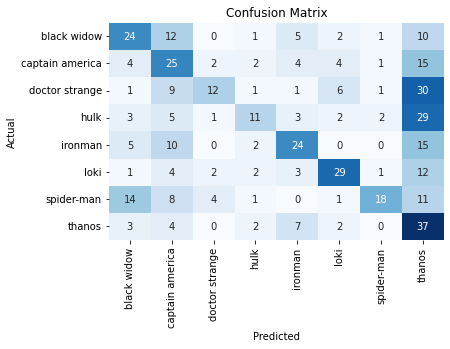

Classification Report:
----------------------
                  precision    recall  f1-score   support

    black widow       0.44      0.44      0.44        55
captain america       0.44      0.32      0.37        77
 doctor strange       0.20      0.57      0.29        21
           hulk       0.20      0.50      0.28        22
        ironman       0.43      0.51      0.47        47
           loki       0.54      0.63      0.58        46
     spider-man       0.32      0.75      0.44        24
         thanos       0.67      0.23      0.35       159

       accuracy                           0.40       451
      macro avg       0.40      0.49      0.40       451
   weighted avg       0.50      0.40      0.40       451



In [22]:
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(8) + 0.5, labels=class_names, rotation=90)
plt.yticks(ticks=np.arange(8) + 0.5, labels=class_names, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n",clr)

In [23]:
f1_score(labels_cpu,preds_cpu,average=None)

array([0.43636364, 0.37313433, 0.29268293, 0.28205128, 0.46601942,
       0.58      , 0.44444444, 0.34579439])